## Sampling the double-well potential with Boltzmann generators

### Section 1. Double-well potential

In this section, 

According to the supplemntary materials of the paper, the equation of the double-well potential is $E(x, y) = ax^{4}-bx^{2}+cx+dy^{2}$
Therefore, we have:
$$\frac{\partial E}{\partial x} = 4ax^{3}-2bx+c=0, \;\frac{\partial E}{\partial y}=dy=0$$
By default, $a=1$, $b=6$, $c=1$, and $d=1$. Solving the equations above,  so the three places with a 0 derivative along with their potential are:
$(-1.7723, 0, -10.7524)$, $(0.08253, 0, 0.0417)$, and $(1.6888, 0, -7.2893)$. Accordingly, the energy difference between the wells is $3.463$.


In [1]:
import numpy as np
import potentials
import generator
import sampling
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm

In [2]:
#np.random.seed(seed=0)
#torch.manual_seed(0)

The coordinates of the minima are: [-1.7723034076580755, 0.0] and [1.6887758209615107, 0.0].
The coordinate of the saddle point is: [0.08352758669656443, 0.0].
The energy difference between the two local minima is: 3.463.
The height of energy barrier is: 10.794.


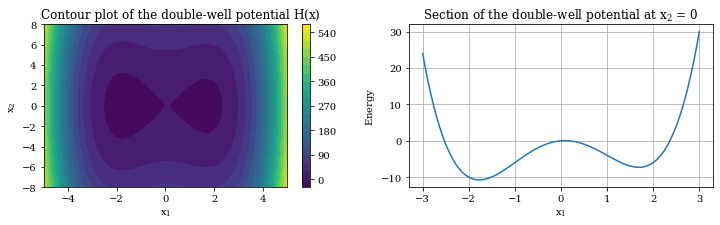

In [3]:
doublewell = potentials.DoubleWellPotential()  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
# another choice: a=0.25, b=1.5, c=1, d=1
doublewell.plot_samples()
print('The coordinates of the minima are: %s and %s.' % (list(doublewell.min_left), list(doublewell.min_right)))
print('The coordinate of the saddle point is: %s.' % list(doublewell.saddle))
print('The energy difference between the two local minima is: %5.3f.' % doublewell.e_diff)
print('The height of energy barrier is: %5.3f.' % doublewell.barrier)

### Section 2. Acquisition of the input dataset from Metropolis Monte Carlo simulations

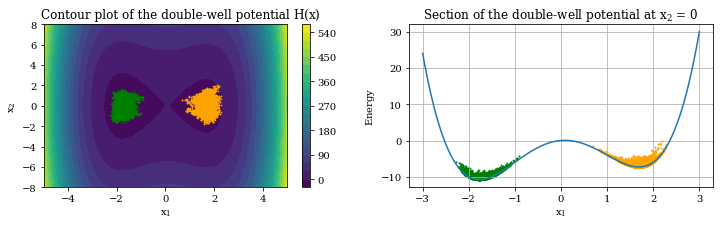

In [4]:
MCsampler1 = sampling.MetropolisSampler(doublewell, doublewell.min_left)
MCsampler1.run(doublewell.min_left, 5000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell, doublewell.min_right)
MCsampler2.run(doublewell.min_right, 5000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')

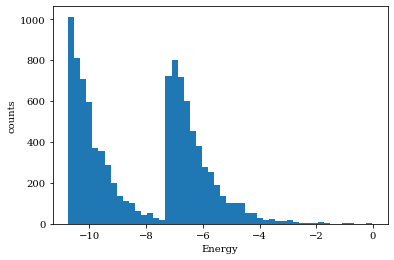

In [5]:
x_samples = np.concatenate((samples1, samples2))  # the training dataset
np.random.shuffle(x_samples) # shuffle rows of data
plt.hist(doublewell.get_energy(x_samples[:, 0], x_samples[:, 1]), bins=50)
plt.xlabel('Energy')
plt.ylabel('counts')
plt.show()

### Section 3. Boltzmann generators
#### Section 3-1. Create a Boltzmann generator

First of all, to create a Boltzmann generator, we have to set up the following parameters:

In [6]:
n_blocks = 8     # number of NVP blocks
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers 
n_iteration = 200
batch_size = 1000
LR = 0.001     # learning rate

Then, to define the architecture of the Boltzmann generator network, we need the following inputs:

In [36]:
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)) 

Below are some notes about the argument to initialize `RealNVP`:
- `prior`: Prior probability distribution:
    - ``prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)``
    - Note that our double-well potential is a 2D function, so the Gaussian distribution must be bivariate. (`dimension=2`)
    - `torch.zeros(2)`: The mean of the bivariate normal distribution, which is a 1-by-2 zero matrix in this case.
    - `torch.eye(2)`: The covariance matrix of the bivariate normal distribution, which is an 2-by-2 identity matrix.
    - To generate 500 samples from the prior distribution, use `prior.sample([500])`.
- `mask`: Masking shceme for affine coupling layers:
    - `masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32))`
    - In `__init__` function of `RealNVP` in `generator.py`, `self.mask = nn.Parameter(mask)` makes the mask as the module parameter. Note that `nn.Parameter` only takes in `torch.Tensor`. (Try printing `nn.Parameter(mask)`.)
- Scaling (`s_net`) and transformation (`t_net`) function in the coupling layers:
    - `torch.nn.Sequential`: A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.
    - In our case here, there are three hidden layers, which are all initialized by `nn.Linear` module, which applies a linear transofmration to the incoming data: $y = x A^{T} + b$. (Note that `nn.Linear` module automatically initializes the weights randomly.)
    - The dimensions of the input and the output of the networks should be 2, which correspond to the dimensionality of the proability distribution. Therefore, the number of input nodes of the first layer and the output node of the last layer are both 2.
    - For `s_net`, except that the last hidden layer uses hyperbolic tangent, other layers all use ReLU as the activation function. However, for `t_net`, there is no activation function for the last layer.
    - In `__init__` function of `RealNVP`, we use `nn.ModuleList`, which is like a Python list used to store a desired number of `nn.Module`’s as `self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])`. 

#### Crescent moons

In [8]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)

ML loss: -15.6685638427734383


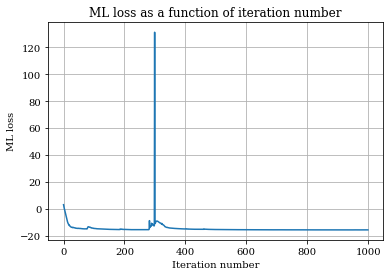

In [9]:
model_test = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer_test = torch.optim.Adam([p for p in model_test.parameters() if p.requires_grad==True], lr=LR) 
training_set_test = noisy_moons.astype('float32')   # note we use samples in latent space here
subdata_test = data.DataLoader(dataset=training_set_test, batch_size=batch_size)  # use trainloader.dataset to check the data
batch_test = torch.from_numpy(subdata_test.dataset)   # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 

n_iteration = 1000
for i in tqdm(range(n_iteration)):
    z, logp = model_test.inverse_generator(torch.from_numpy(noisy_moons))
    loss = -(model_test.prior.log_prob(z) + logp).mean()
    #loss = model_test.loss_ML(batch)  # note that batch here are the samples in the latent space!
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    
    # start training
    optimizer_test.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer_test.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()

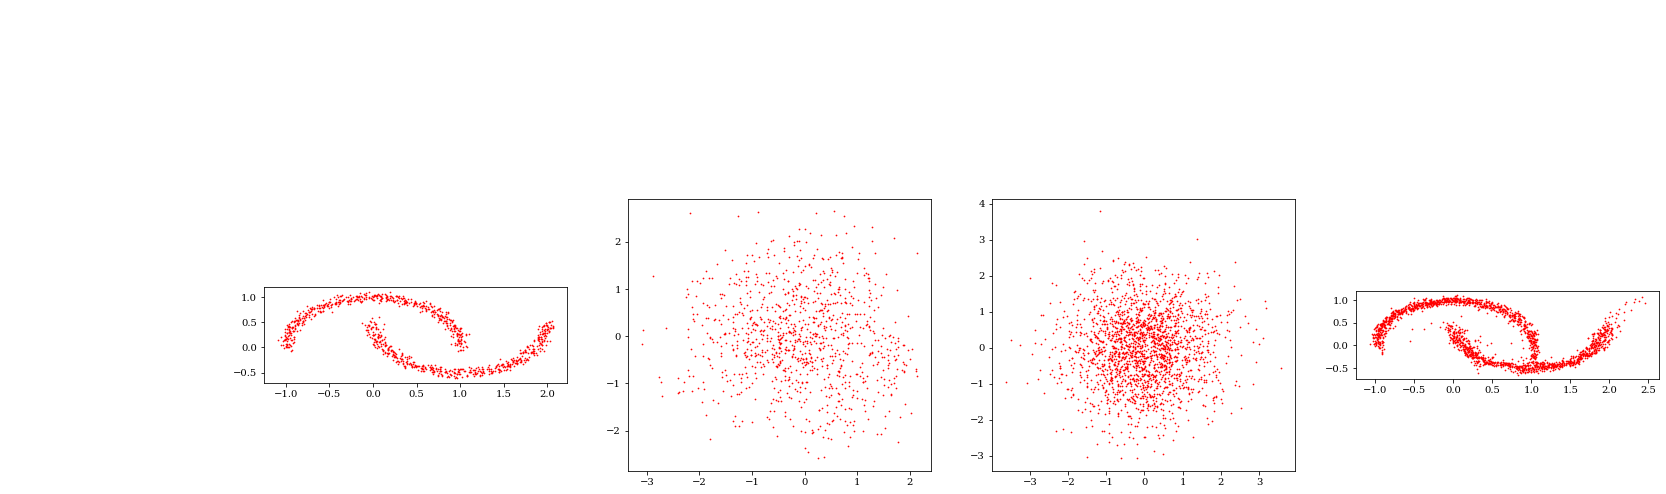

In [10]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], color='red', s=0.5) 
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_test.inverse_generator(torch.from_numpy(noisy_moons.astype('float32')))[0].detach().numpy()

plt.subplot(1, 4, 2)
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
#plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(2000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='red', s=0.5)


# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_test.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='red', s=0.5)
ax = plt.gca()
ax.set_aspect(0.58)

#### Section 3-2. Training by examples
According to Figure 1. in the Boltzmann generator paper, the steps of generating a sample in the configuration space using a Boltzmann generator are:
- **Step 1**: Generate samples from the probability distribution in the configuration space. (Done in Monte Carlo simulation in Section 2.)
- **Step 2**: Use the samples obtained in Step 1. to train the inverse generator $F_{xz}$ (or $G^{-1}$). (`inverse_generator` in `RealNVP`).
- **Step 3**: After the inverse generator is trained, generate samples from the prior distribution in the latent space (`latent_sampler` in `RealNVP`).
- **Step 4**: Use the samples obtained in Step 3 as the input to the generator $F_{zx}$ (or $G$). (`generator` in `RealNVP`)

ML loss: -17.573991775512695


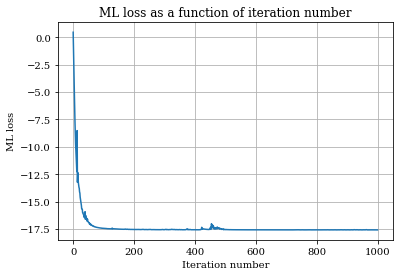

In [11]:
model_ML = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.Adam([p for p in model_ML.parameters() if p.requires_grad==True], lr=LR) 
training_set = x_samples.astype('float32')
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 

for i in tqdm(range(n_iteration)):
    loss = model_ML.loss_ML(batch)
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    
    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    tqdm.write("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()

As shown above, the ML loss reach equilibration after about 80 interaions, which indicates that the inverse generator is successfully trained. However, to make sure, we still have to look into the samples generated in the real/configuration space by the generator. 

In [12]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

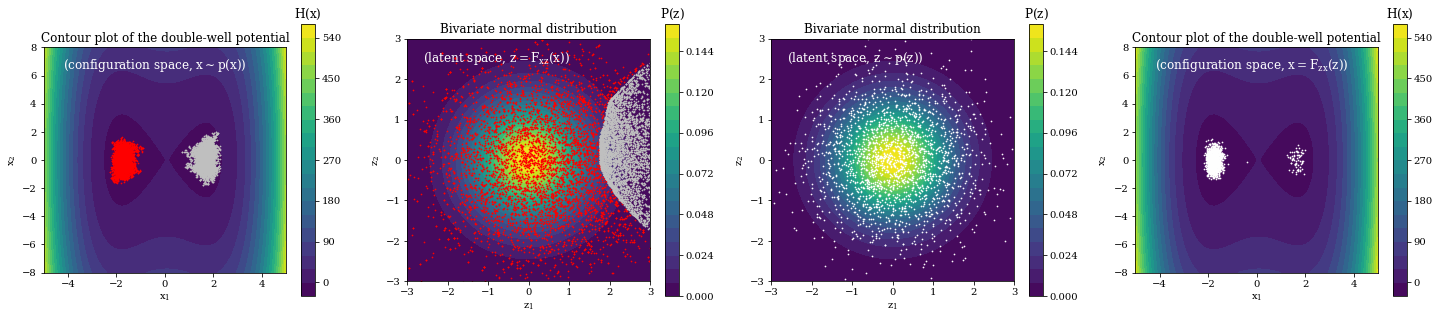

In [18]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_ML.inverse_generator(torch.from_numpy(samples1.astype('float32')))[0].detach().numpy()
z2 = model_ML.inverse_generator(torch.from_numpy(samples2.astype('float32')))[0].detach().numpy()


plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(2000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_ML.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

#### Section 3-3. Training by energy

In [ ]:
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.Tanh(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)) 

model_KL = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.AdamW([p for p in model_KL.parameters() if p.requires_grad==True], lr=LR, amsgrad=False) 
z_samples = prior.sample_n(1000).detach().numpy()  
training_set = z_samples.astype('float32')   # note we use samples in latent space here
subdata = data.DataLoader(dataset=training_set, batch_size=1000)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 

n_iteration = 200
for i in tqdm(range(n_iteration)):
    loss = model_KL.loss_KL(batch)  # note that batch here are the samples in the latent space!
    """
    if len(loss_list) > 1 and loss - loss_list[-1] >= 2:
        xx, xlog_R_zx = model_KL.generator(batch)
        u_xx = model_KL.calculate_energy(xx)
        print('iteration %s' % i)
        print('KL loss at iteration %s: %s' % (i - 1, loss_list[-1])) 
        print('KL loss at iteration %s: %s' % (i, loss.item()))
        print('u_x = ', u_xx)
        print('log_Rzx = ', xlog_R_zx)
        print('u_x - log_Rzx = ', u_xx - xlog_R_zx) 
        print('weigts: ', model_KL.weights)
        print('\n')
    """
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    
    
    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('KL loss')
plt.title('KL loss as a function of iteration number')
plt.grid()

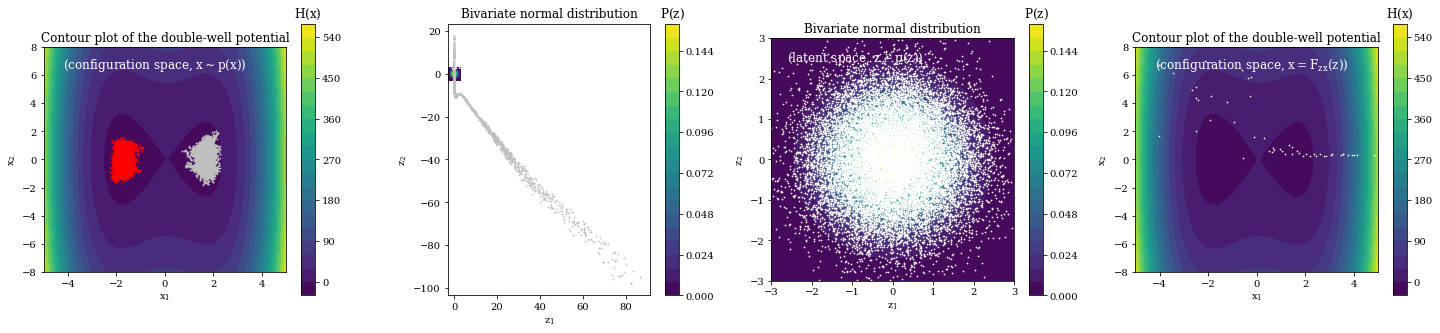

In [43]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_KL.inverse_generator(torch.from_numpy(samples1.astype('float32')))[0].detach().numpy()
z2 = model_KL.inverse_generator(torch.from_numpy(samples2.astype('float32')))[0].detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(20000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_KL.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

#### Section 3-4. Training by example and energy at the same time

In [ ]:
model_KLML = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.Adam([p for p in model_KLML.parameters() if p.requires_grad==True], lr=LR) 
training_set_x = x_samples.astype('float32')
training_set_z = z_samples.astype('float32')
subdata_x = data.DataLoader(dataset=training_set_x, batch_size=batch_size) 
subdata_z = data.DataLoader(dataset=training_set_z, batch_size=batch_size)  
batch_x = torch.from_numpy(subdata_x.dataset)   
batch_z = torch.from_numpy(subdata_z.dataset)
loss_list = []   # saving the loss as a function of iteration number 
for i in tqdm(range(n_iteration)):
    loss_ML = model_KLML.loss_ML(batch_x)
    loss_KL = model_KLML.loss_KL(batch_z)
    loss = loss_KL + loss_ML
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    # start training
    optimizer.zero_grad() 
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('KL loss')
plt.title('KL loss as a function of iteration number')
plt.grid()

In [ ]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_KLML.inverse_generator(torch.from_numpy(samples1.astype('float32')))[0].detach().numpy()
z2 = model_KLML.inverse_generator(torch.from_numpy(samples2.astype('float32')))[0].detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(2000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_KLML.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

#### Section 4. Free energy calculations

After confirming that the Boltzmann generator we built was able to generate correct distributions, we can use to to calculate free energy as a function of reaction coordinate, which is $x_{1}$ in this case. Specifically, the reduced free energy of the system can be calculated as:$f=-\ln p(x) + \text{constant}$, where $\text{constant}$ is actually $\ln Z_{x}$. Since we are only able to calculate energy differences rather than the absolute difference,  shifting the minimum of the free energy to 0 (so that the constant is 0) would give $f=\ln p(x)$. 

In [ ]:
centers

In [ ]:
np.exp(-doublewell.get_energy(centers))

In [ ]:
z_f = prior.sample_n(500000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

counts, bins = np.histogram(x_f[:, 0], bins=20)
probs = counts / np.sum(counts)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()

In [ ]:
hist_data = plt.hist(x_f[:, 0], edgecolor='black', bins=20)
# hist_data[0]: counts of each bin, hist_data[1]: the edges of each bin

In [ ]:
bins.shape

In [ ]:
bins

In [ ]:
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])     # the center of each bin ("bins" are the edges of the bins)

In [ ]:
centers

In [ ]:
x1 = x_fe[:,0]
x2 = x_fe[:,1]

counts, bins = np.histogram(x1, bins = 200)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)
plt.figure()
plt.scatter()


# Visualize the results
plt.scatter(anchors, fn) 

plt.xlabel("$x_1$")
plt.ylabel(r"$(f - f_0) / k_B T$")

plt.show()

### Free Energy
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by:
$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

Parameters to try
- Different masking schemes
- Different activation functions in each layer of the neural networks (s_net and t_net).
- Whether to use an activation function in the output layer.


### Todos
- Read RealNVP paper
- Read Boltzmann generators paper
- Prepare the second test system
- Check REMD of PLCpep7

### Mueller Brown potential

In [ ]:
aj = np.array([-1, -1, -6.5, 0.7])
bj = np.array([0, 0, 11, 0.6])
cj = np.array([-10, -10, 6.5, 0.7])
Aj = np.array([-200, -100, -170, 15])
xj = np.array([1, 0, -0.5, -1])
yj = np.array([0, 0.5, 1.5, 1])

mueller = potentials.MuellerPotential(aj, bj, cj, Aj, xj, yj)

In [ ]:
def plot_contour(potential, x_range, y_range, grid = [100, 100]):
    x = np.linspace(x_range[0],x_range[1], grid[0])
    y = np.linspace(y_range[0],y_range[1], grid[1])
    X, Y = np.meshgrid(x, y)
    E = potential(X, Y)
    print(E)
    plt.figure()
    plt.contourf(X, Y, E, np.linspace(-1.5,1.5, 1000))
    plt.colorbar()

In [ ]:
plot_contour(mueller, [-1, 1], [0, 2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors